# **Introducción**
 ## ¿Qué es Johnson & Johnson (JNJ)?

Johnson & Johnson es una empresa global del sector salud, reconocida por desarrollar:

- Medicamentos y biotecnología

- Dispositivos médicos

- Productos de cuidado personal

- Es una de las compañías más grandes e influyentes del mundo en su industria.

## ¿Para qué sirve JNJ y cómo funciona?

JNJ opera a través de tres líneas principales:

1. **Pharmaceuticals** – desarrollo de medicamentos especializados.

2. **MedTech / Medical Devices** – tecnologías para cirugía, cardiología, ortopedia, etc.

3. **Consumer Health** – productos de uso cotidiano relacionados con bienestar y salud.

Su funcionamiento se basa en investigación, innovación constante y una cadena global de producción y distribución en el sector salud.

## ¿Qué variable analizamos?

En este proyecto analizo:

### **Precio histórico de la acción de JNJ (ticker: JNJ)**

Esta serie refleja cómo el mercado valora el desempeño, estabilidad y expectativas futuras de la empresa.

## ¿Por qué esta serie es relevante?

- JNJ es un **referente del sector salud**, un sector clave y defensivo en la economía.

- Su acción se usa frecuentemente como indicador de **estabilidad financiera**.

- Es útil para análisis de riesgo, inversiones y toma de decisiones profesionales en finanzas o negocios.

## ¿Cuál es la motivación del pronóstico?

Queremos comprender cómo podría comportarse el precio de la acción en el futuro para apoyar:

- Evaluaciones de inversión

- Planeación estratégica

- Estudios académicos sobre modelos de predicción

- Análisis de tendencias financieras

## Objetivo del pronóstico

Construir un modelo capaz de **predecir la evolución futura del precio de la acción de JNJ**, identificando su tendencia, posibles cambios y patrones relevantes usando técnicas de series de tiempo y modelos no lineales.

# Librerias

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import plotly.graph_objects as go


c:\Users\david\anaconda3\envs\tf_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Obtener Datos de Jhonson & Jhonson

In [3]:
df = yf.download("JNJ", start="2015-01-01", end="2025-12-02")
df.head()

C:\Users\david\AppData\Local\Temp\ipykernel_27620\1044092884.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("JNJ", start="2015-01-01", end="2025-12-02")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,JNJ,JNJ,JNJ,JNJ,JNJ
Date,,,,,
2015-01-02,76.955544,77.713912,76.668396,77.345774,5753600
2015-01-05,76.418091,77.110192,76.337100,76.926123,8079300
2015-01-06,76.042580,77.301611,75.792249,76.823030,7428000
2015-01-07,77.721275,77.920073,76.432793,76.506425,7931700
2015-01-08,78.332397,78.406024,77.861181,78.089425,9916000


In [4]:
# Variable a pronosticar
serie = df["Close"]
serie.head()

Ticker,JNJ
Date,
2015-01-02,76.955544
2015-01-05,76.418091
2015-01-06,76.042580
2015-01-07,77.721275
2015-01-08,78.332397


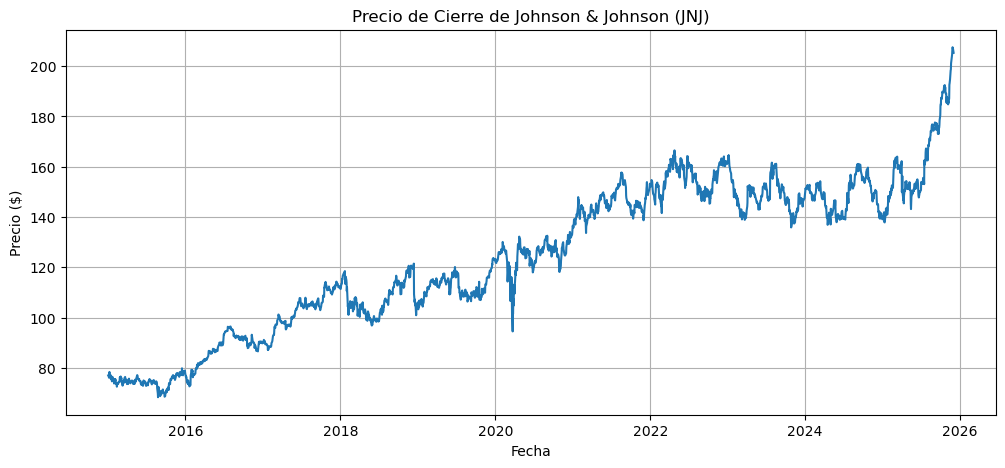

In [5]:
plt.figure(figsize=(12,5))
plt.plot(serie)
plt.title("Precio de Cierre de Johnson & Johnson (JNJ)")
plt.xlabel("Fecha")
plt.ylabel("Precio ($)")
plt.grid(True)
plt.show()


# Limpieza

In [6]:
df.isna().sum()

Price   Ticker
Close   JNJ       0
High    JNJ       0
Low     JNJ       0
Open    JNJ       0
Volume  JNJ       0
dtype: int64

In [7]:
df = df.dropna()

In [8]:
# Verificar duplicados en el índice
df.index.duplicated().sum()

0

In [9]:
# Verificar que el índice esté ordenado
df = df.sort_index()

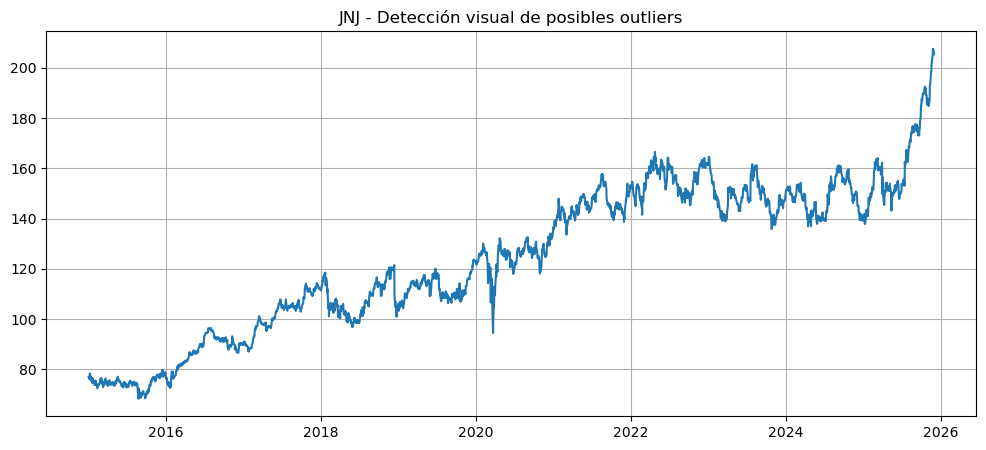

In [10]:
# Visualizar Outliers
plt.figure(figsize=(12,5))
plt.plot(df["Close"])
plt.title("JNJ - Detección visual de posibles outliers")
plt.grid(True)
plt.show()

In [11]:
# Comprobar que el indice es de tipo datetime
df.index = pd.to_datetime(df.index)
df.index.dtype

dtype('<M8[ns]')

# EDA

In [12]:
df["Close"].describe()

Ticker,JNJ
count,2745.000000
mean,124.296446
std,29.269976
min,68.278847
25%,103.107536
50%,125.672539
75%,149.285889
max,207.559998


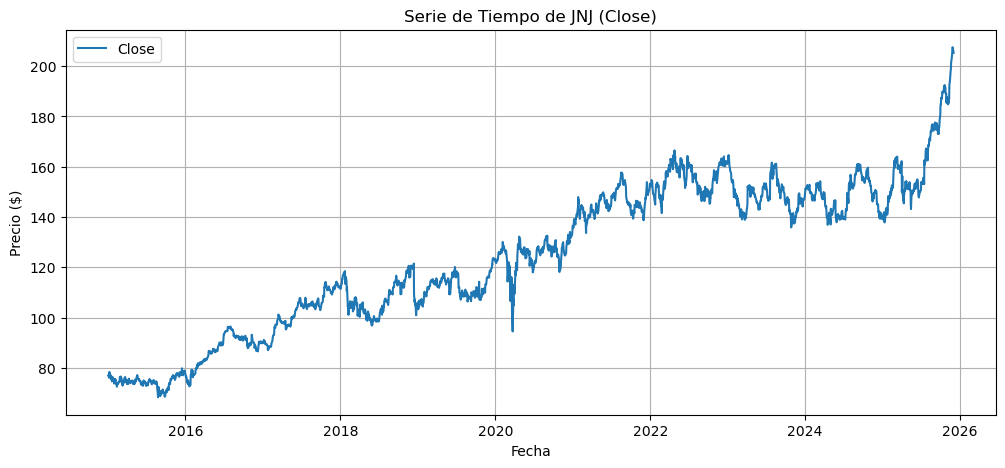

In [13]:
plt.figure(figsize=(12,5))
plt.plot(df["Close"], label="Close")
plt.title("Serie de Tiempo de JNJ (Close)")
plt.ylabel("Precio ($)")
plt.xlabel("Fecha")
plt.grid(True)
plt.legend()
plt.show()

- La gráfica muestra un crecimiento sostenido desde 2015 hasta el 2 de diciembre de 2025.
- La tendencia es muy clara, ascendente y sin grandes rupturas estructurales.
- La volatilidad es moderada: hay subidas y bajadas, pero no existen picos extremos.
- Se observa estabilidad incluso en periodos turbulentos, lo cual hace a JNJ una serie bastante predecible.

<Figure size 1200x500 with 0 Axes>

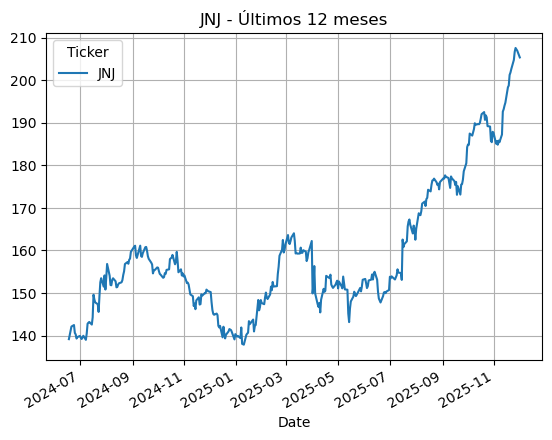

In [14]:
# Zoon del ultimo año
plt.figure(figsize=(12,5))
df["Close"].tail(365).plot()
plt.title("JNJ - Últimos 12 meses")
plt.grid(True)
plt.show()

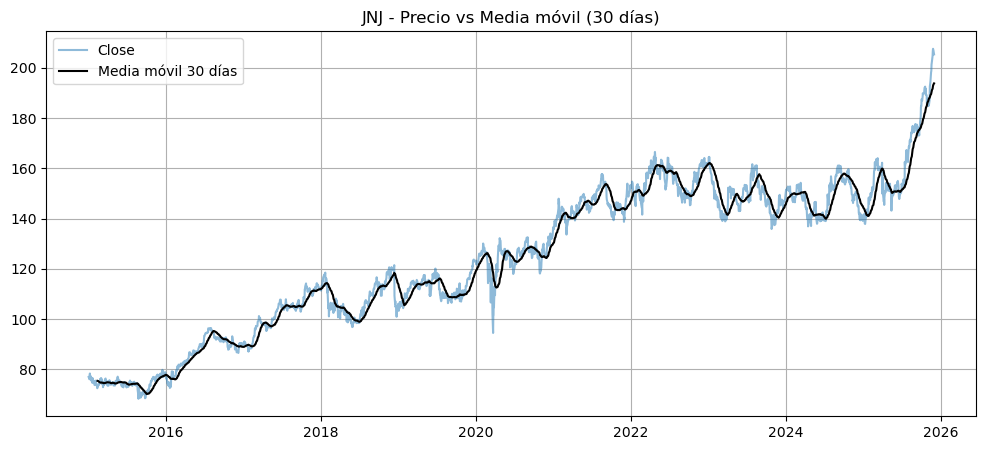

In [15]:
# Media movil
plt.figure(figsize=(12,5))
plt.plot(df["Close"], label="Close", alpha=0.5)
plt.plot(df["Close"].rolling(window=30).mean(), label="Media móvil 30 días", color='black')
plt.title("JNJ - Precio vs Media móvil (30 días)")
plt.grid(True)
plt.legend()
plt.show()

- La media móvil suaviza el ruido diario y confirma la tendencia ascendente.
- El precio se mueve ordenadamente alrededor de la media móvil.
- No hay cambios bruscos ni ruido irregular.

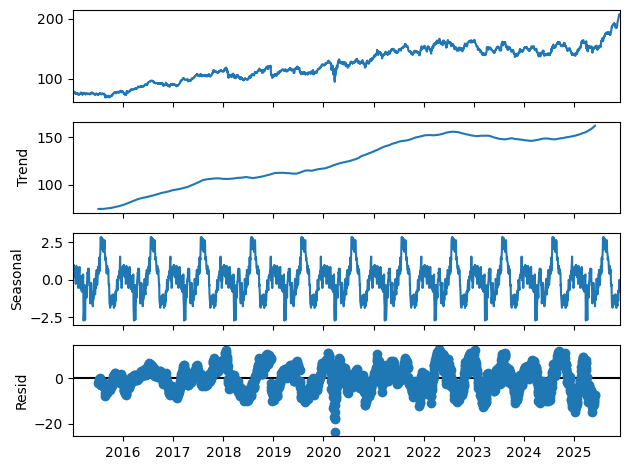

In [16]:
result = seasonal_decompose(df["Close"], model="additive", period=252)  # 252 = días de mercado por año
result.plot()
plt.show()

## Tendencia

- Muy clara, suave y creciente.

- No muestra cambios abruptos en la dirección general.

- Una tendencia así suele ser fácil de aprender por un modelo.

## Estacionalidad

- La estacionalidad es suave, pequeña y repetitiva.

- Parece ligeramente anual o de ciclos de varios meses.

- No es fuerte, pero sí existe un patrón repetido.

## Residuo

- Fluctúa alrededor de 0, con valores moderados.

- Un outlier notable en 2020 (caída del COVID), totalmente esperado en datos reales.

- El resto se mantiene en rangos normales por lo que no hay ruido excesivo.

<Figure size 1200x400 with 0 Axes>

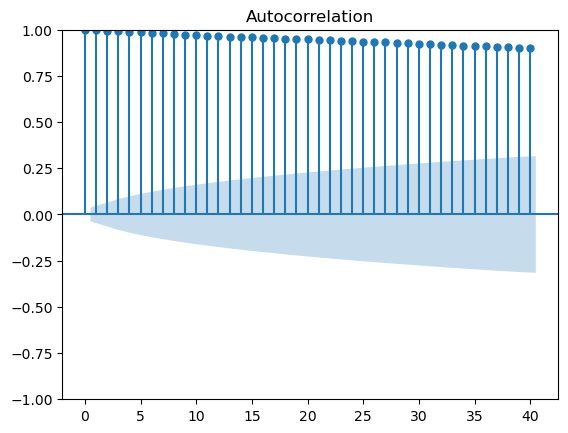

<Figure size 1200x400 with 0 Axes>

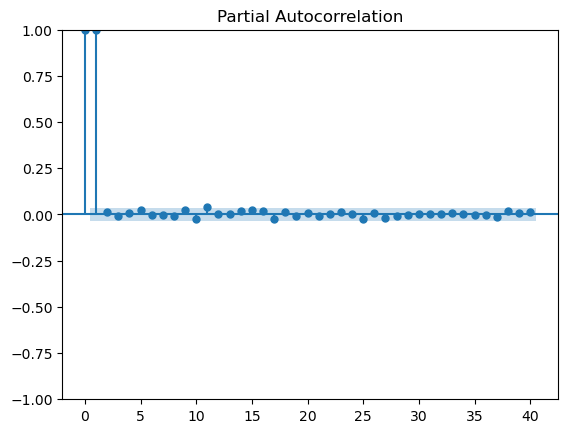

In [17]:
plt.figure(figsize=(12,4))
plot_acf(df["Close"], lags=40)
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(df["Close"], lags=40)
plt.show()

## Autocorrelación (ACF)

- La ACF muestra correlaciones muy altas incluso en los primeros 40 rezagos.
- Esto significa que el precio depende fuertemente de los valores pasados, típica en acciones.
- Es un indicio de que un modelo LSTM/CNN tendrá qué aprender (dependencia temporal consistente).

## Autocorrelación Parcial (PACF)

- El rezago 1 y 2 son los más significativos.
- A partir del rezago 3, las correlaciones prácticamente desaparecen.

Lo que significa que:

- ACF = lenta disminución

- PACF = uno o dos rezagos fuertes

# Preparacion de datos

In [18]:
df = df.sort_index()
serie = df["Close"]


In [19]:
# Usamos df["Close"] ya limpio
data = df[["Close"]].copy()

train_size = int(len(data) * 0.80)
train_df = data.iloc[:train_size]
test_df  = data.iloc[train_size:]


In [20]:
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_df)
test_scaled  = scaler.transform(test_df)

In [21]:
window_size = 60  # ajustable

def create_sequences(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, window_size)
X_test, y_test   = create_sequences(test_scaled,  window_size)

In [22]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test  = X_test.reshape(X_test.shape[0],  X_test.shape[1],  1)


# CNN

In [23]:
cnn_model = Sequential()

# Capa convolucional 1D
cnn_model.add(Conv1D(
    filters=64,
    kernel_size=3,
    activation='relu',
    input_shape=(X_train.shape[1], X_train.shape[2])
))

# Pooling para reducir dimensionalidad
cnn_model.add(MaxPooling1D(pool_size=2))

# Otra capa opcional (puedes comentarla si quieres algo más simple)
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))

# Aplanar
cnn_model.add(Flatten())

# Capa densa intermedia
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.2))  # ligera regularización

# Capa de salida (un solo valor: precio siguiente)
cnn_model.add(Dense(1))

cnn_model.compile(optimizer='adam', loss='mse')
cnn_model.summary()


c:\Users\david\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 58, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 27, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 13, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 416)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        26,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,185 (129.63 KB)

 Trainable params: 33,185 (129.63 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_cnn = cnn_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0240 - val_loss: 0.0044
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0043
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0046
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - val_loss: 0.0030
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 10/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 11/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 12/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_lo

In [25]:
# Predicción en test (en escala normalizada)
y_pred_test_scaled = cnn_model.predict(X_test)

# Invertimos el escalado
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_test_inv = scaler.inverse_transform(y_pred_test_scaled)

# Métricas
mse_test  = mean_squared_error(y_test_inv, y_pred_test_inv)
rmse_test = np.sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test_inv, y_pred_test_inv)

mse_test, rmse_test, mape_test


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


(22.057525526206547, 4.6965439981125, 0.021528364152506103)

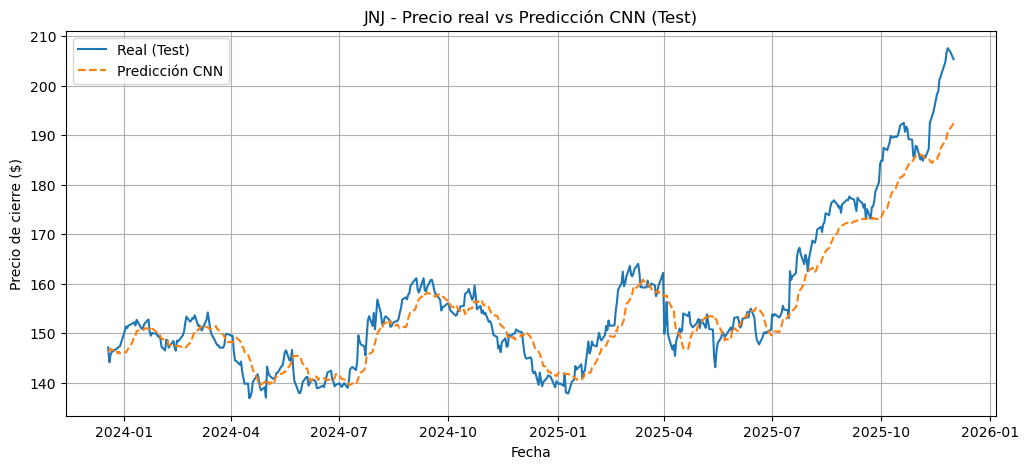

In [26]:
# El índice de test pierde los primeros "window_size" puntos por las ventanas
test_index = test_df.index[window_size:]

plt.figure(figsize=(12,5))
plt.plot(test_index, y_test_inv, label='Real (Test)')
plt.plot(test_index, y_pred_test_inv, label='Predicción CNN', linestyle='--')
plt.title('JNJ - Precio real vs Predicción CNN (Test)')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre ($)')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
# --- 1. Obtener la última ventana de la serie completa (ya escalada) ---

# Escalamos toda la serie con el scaler ya entrenado en train
scaled_full = scaler.transform(df[["Close"]])

# Últimos 'window_size' puntos
last_window = scaled_full[-window_size:]
sequence = last_window.reshape(1, window_size, 1)  # (1, timesteps, features)

# --- 2. Predicción autoregresiva a 30 días ---

future_steps = 30
future_preds_scaled = []

for _ in range(future_steps):
    # Predicción del siguiente valor (en escala normalizada)
    next_scaled = cnn_model.predict(sequence, verbose=0)
    future_preds_scaled.append(next_scaled[0, 0])

    # Desplazar ventana e insertar la predicción al final
    sequence = np.roll(sequence, -1, axis=1)
    sequence[0, -1, 0] = next_scaled[0, 0]

future_preds_scaled = np.array(future_preds_scaled).reshape(-1, 1)

# --- 3. Invertir el escalado (volver a precios reales) ---

future_preds = scaler.inverse_transform(future_preds_scaled).flatten()

# --- 4. Crear fechas futuras (30 días hábiles después del último dato) ---

last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1),
                             periods=future_steps,
                             freq='B')  # 'B' = Business days

# --- 5. Crear tabla con las predicciones ---

future_cnn_df = pd.DataFrame({
    "Fecha futura": future_dates,
    "Predicción del precio ($)": future_preds
})

future_cnn_df.head(30)


,Fecha futura,Predicción del precio ($)
0,2025-12-02,193.120224
1,2025-12-03,194.114944
2,2025-12-04,194.764420
3,2025-12-05,195.530075
4,2025-12-08,195.354111
5,2025-12-09,195.188477
6,2025-12-10,195.261139
7,2025-12-11,194.711349
8,2025-12-12,194.023590
9,2025-12-15,193.695221


c:\Users\david\anaconda3\envs\tf_env\lib\site-packages\matplotlib\text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
c:\Users\david\anaconda3\envs\tf_env\lib\site-packages\matplotlib\text.py:763: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(y))


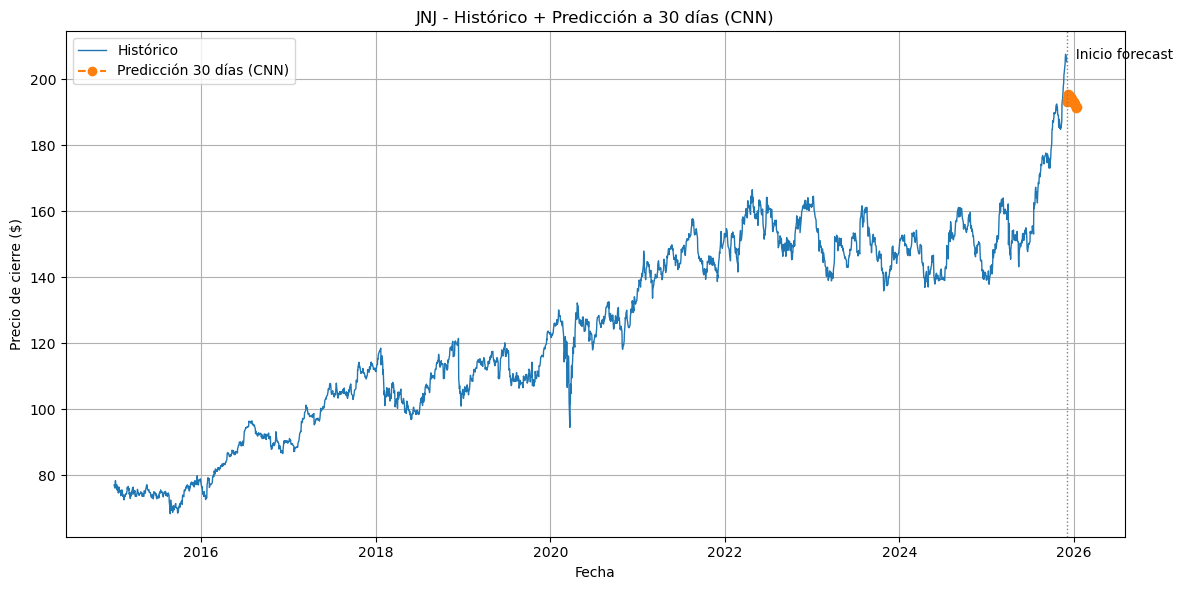

In [28]:
plt.figure(figsize=(12,6))

# 1. Histórico completo
plt.plot(df.index, df["Close"], label="Histórico", linewidth=1)

# 2. Predicción a 30 días (CNN)
plt.plot(future_cnn_df["Fecha futura"], future_cnn_df["Predicción del precio ($)"],
         label="Predicción 30 días (CNN)", linestyle="--", marker="o")

# 3. Línea vertical marcando el punto donde empieza la predicción
plt.axvline(x=df.index[-1], color="gray", linestyle=":", linewidth=1)
plt.text(df.index[-1], df["Close"].iloc[-1],
         "  Inicio forecast", verticalalignment="bottom")

plt.title("JNJ - Histórico + Predicción a 30 días (CNN)")
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


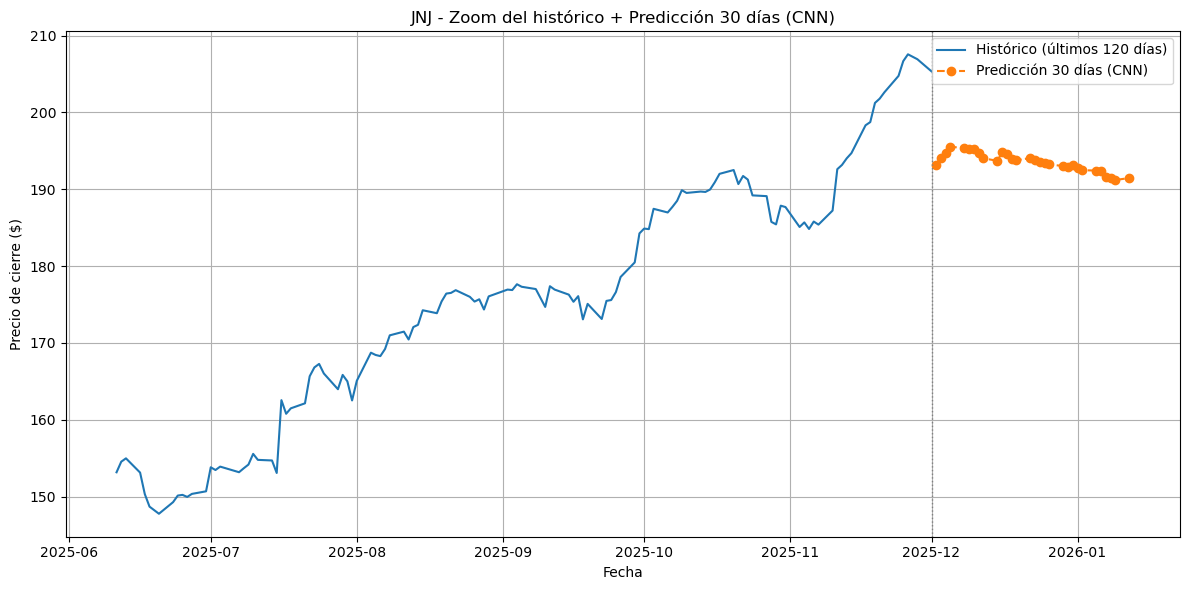

In [29]:
# Número de días del histórico que quieres mostrar
zoom_days = 120

# Recorte del histórico
df_zoom = df.iloc[-zoom_days:].copy()

plt.figure(figsize=(12,6))

# 1. Histórico recortado
plt.plot(df_zoom.index, df_zoom["Close"], label="Histórico (últimos 120 días)")

# 2. Predicción a 30 días CNN
plt.plot(future_cnn_df["Fecha futura"], 
         future_cnn_df["Predicción del precio ($)"],
         label="Predicción 30 días (CNN)", linestyle="--", marker="o")

# Línea vertical indicando el punto donde comienza el forecast
plt.axvline(x=df.index[-1], color="gray", linestyle=":", linewidth=1)

plt.title("JNJ - Zoom del histórico + Predicción 30 días (CNN)")
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# LSTM

In [30]:
from tensorflow.keras.layers import LSTM, Dense, Dropout

lstm_model = Sequential()

# Capa LSTM principal
lstm_model.add(LSTM(
    units=64,
    return_sequences=False,
    input_shape=(X_train.shape[1], X_train.shape[2])
))

# Regularización ligera
lstm_model.add(Dropout(0.2))

# Capa densa intermedia
lstm_model.add(Dense(32, activation='relu'))

# Capa de salida (un solo valor)
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()


c:\Users\david\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
early_stop_lstm = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=50,          # puedes subirlo a 100 si ves que no sobreajusta
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop_lstm],
    verbose=1
)


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0273 - val_loss: 0.0076
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0016 - val_loss: 8.8253e-04
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011 - val_loss: 7.1956e-04
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012 - val_loss: 0.0039
Epoch 10/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 11/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0010 - val_loss: 8.1348e-04
Epoch 12/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

In [32]:
# Predicción en test (escala normalizada)
y_pred_test_lstm_scaled = lstm_model.predict(X_test)

# Invertir escalado
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_test_lstm_inv = scaler.inverse_transform(y_pred_test_lstm_scaled)

# Métricas
mse_lstm  = mean_squared_error(y_test_inv, y_pred_test_lstm_inv)
rmse_lstm = np.sqrt(mse_lstm)
mape_lstm = mean_absolute_percentage_error(y_test_inv, y_pred_test_lstm_inv)

mse_lstm, rmse_lstm, mape_lstm


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


(7.884560697242533, 2.807945992579368, 0.013748804690490399)

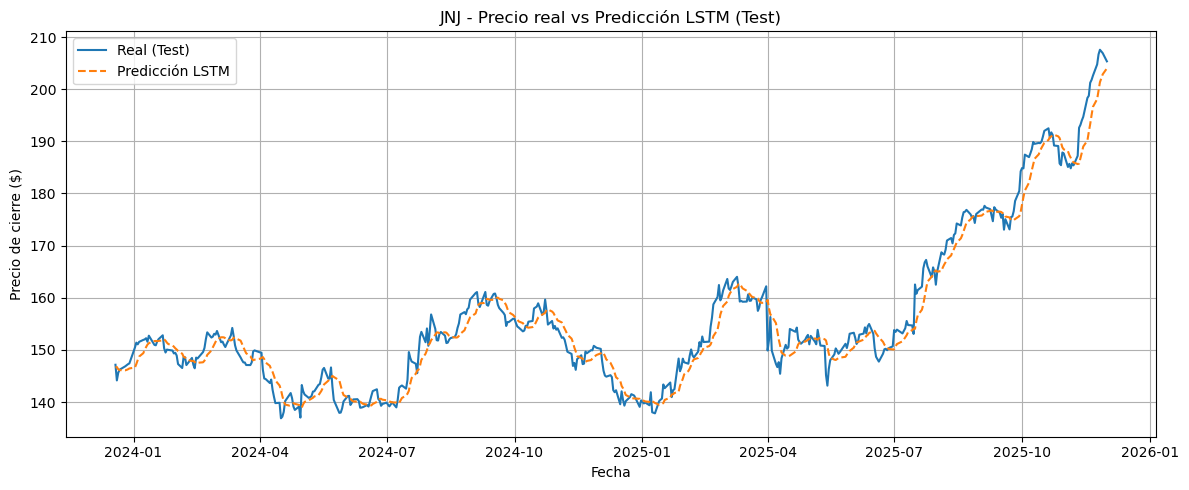

In [33]:
# Índice de test ajustado por las ventanas
test_index = test_df.index[window_size:]

plt.figure(figsize=(12,5))
plt.plot(test_index, y_test_inv, label='Real (Test)')
plt.plot(test_index, y_pred_test_lstm_inv, label='Predicción LSTM', linestyle='--')
plt.title('JNJ - Precio real vs Predicción LSTM (Test)')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
# --- 1. Obtener última ventana de la serie completa (escalada) ---

scaled_full = scaler.transform(df[["Close"]])

last_window_lstm = scaled_full[-window_size:]
sequence_lstm = last_window_lstm.reshape(1, window_size, 1)

# --- 2. Predicción autoregresiva a 30 días con LSTM ---

future_steps = 30
future_lstm_scaled = []

for _ in range(future_steps):
    next_scaled = lstm_model.predict(sequence_lstm, verbose=0)
    future_lstm_scaled.append(next_scaled[0, 0])
    
    # Desplazar ventana e insertar la nueva predicción
    sequence_lstm = np.roll(sequence_lstm, -1, axis=1)
    sequence_lstm[0, -1, 0] = next_scaled[0, 0]

future_lstm_scaled = np.array(future_lstm_scaled).reshape(-1, 1)

# --- 3. Invertir el escalado ---

future_lstm = scaler.inverse_transform(future_lstm_scaled).flatten()

# --- 4. Fechas futuras (mismas que para la CNN si ya existen) ---

last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1),
                             periods=future_steps,
                             freq='B')  # días hábiles

# --- 5. Tabla de predicción LSTM ---

future_lstm_df = pd.DataFrame({
    "Fecha futura": future_dates,
    "Predicción LSTM ($)": future_lstm
})

future_lstm_df.head(30)
future_lstm_df.style.format({"Predicción LSTM ($)": "{:,.2f}"})


,Fecha futura,Predicción LSTM ($)
0,2025-12-02 00:00:00,204.63
1,2025-12-03 00:00:00,204.96
2,2025-12-04 00:00:00,205.19
3,2025-12-05 00:00:00,205.33
4,2025-12-08 00:00:00,205.41
5,2025-12-09 00:00:00,205.44
6,2025-12-10 00:00:00,205.43
7,2025-12-11 00:00:00,205.38
8,2025-12-12 00:00:00,205.30
9,2025-12-15 00:00:00,205.21


# COmparacion de CNN VS LSTM

In [35]:
# Asumiendo que ya tenías estas métricas de la CNN:
# mse_test, rmse_test, mape_test

mse_cnn  = mse_test
rmse_cnn = rmse_test
mape_cnn = mape_test


In [40]:
metricas_df = pd.DataFrame({
    "Modelo": ["CNN", "LSTM"],
    "MSE": [mse_cnn, mse_lstm],
    "RMSE": [rmse_cnn, rmse_lstm],
    "MAPE": [mape_cnn, mape_lstm]
})

metricas_df

metricas_df.style.format({
    "MSE": "{:,.4f}",
    "RMSE": "{:,.4f}",
    "MAPE": "{:.4%}"
})


,Modelo,MSE,RMSE,MAPE
0,CNN,22.0575,4.6965,2.1528%
1,LSTM,7.8846,2.8079,1.3749%


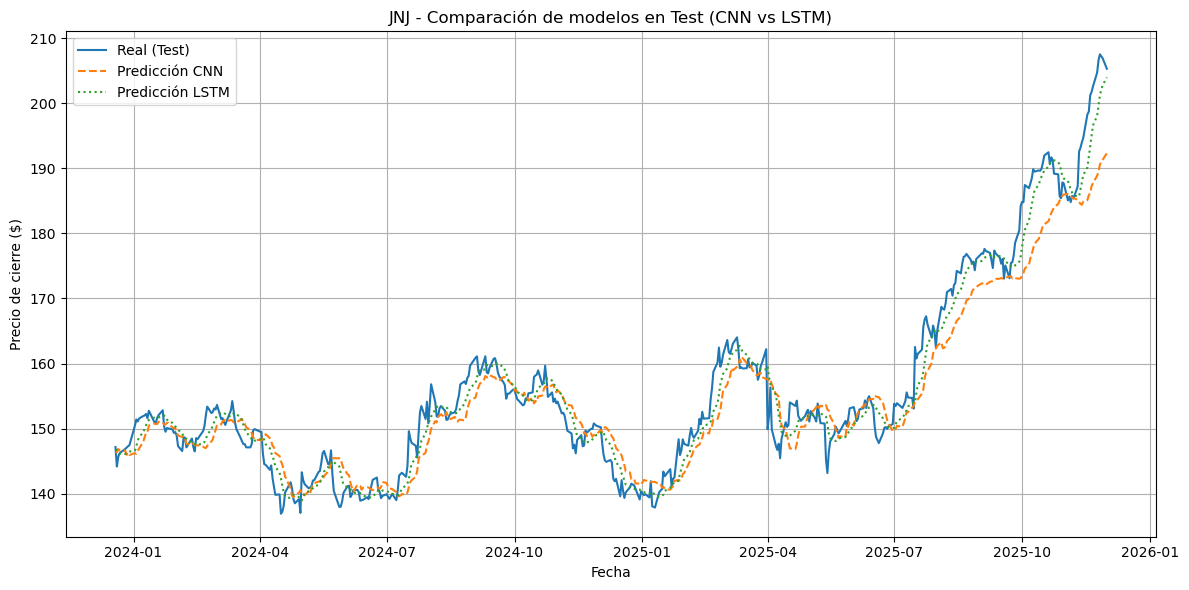

In [37]:
# Índice del test ajustado por el window_size
test_index = test_df.index[window_size:]

plt.figure(figsize=(12,6))

plt.plot(test_index, y_test_inv, label="Real (Test)", linewidth=1.5)
plt.plot(test_index, y_pred_test_inv,        label="Predicción CNN",  linestyle="--")
plt.plot(test_index, y_pred_test_lstm_inv,   label="Predicción LSTM", linestyle=":")

plt.title("JNJ - Comparación de modelos en Test (CNN vs LSTM)")
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


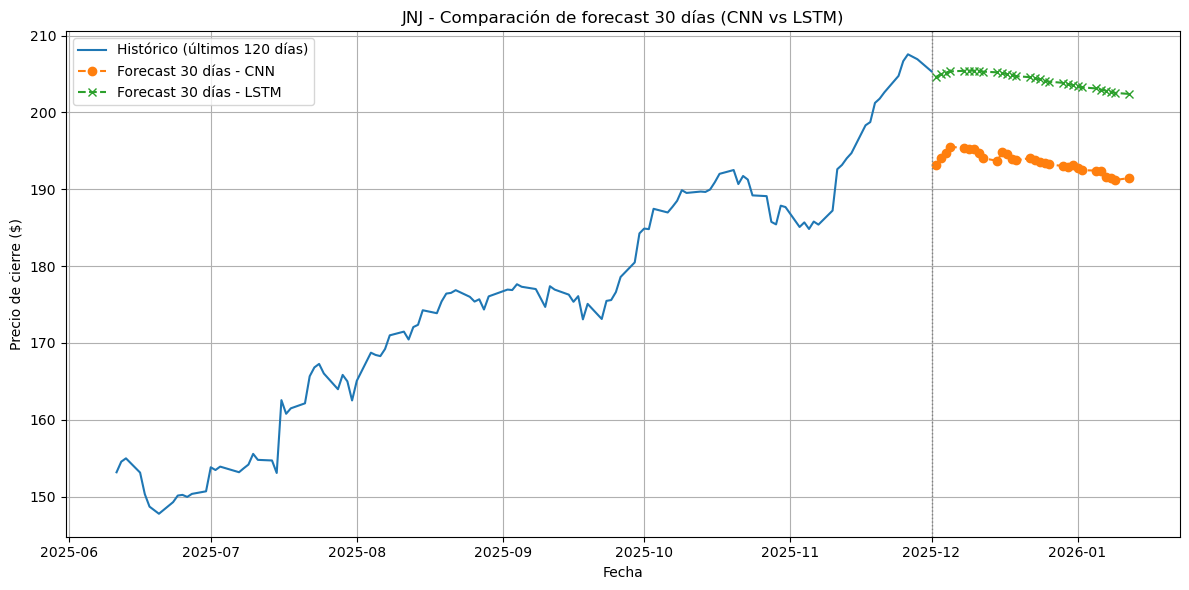

In [38]:
plt.figure(figsize=(12,6))

# Últimos días históricos (por ejemplo 120) para contexto
zoom_days = 120
df_zoom = df.iloc[-zoom_days:].copy()

plt.plot(df_zoom.index, df_zoom["Close"], label="Histórico (últimos 120 días)")

# Forecast CNN
plt.plot(future_cnn_df["Fecha futura"], 
         future_cnn_df["Predicción del precio ($)"],
         label="Forecast 30 días - CNN",
         linestyle="--", marker="o")

# Forecast LSTM
plt.plot(future_lstm_df["Fecha futura"],
         future_lstm_df["Predicción LSTM ($)"],
         label="Forecast 30 días - LSTM",
         linestyle="--", marker="x")

plt.axvline(x=df.index[-1], color="gray", linestyle=":", linewidth=1)

plt.title("JNJ - Comparación de forecast 30 días (CNN vs LSTM)")
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
